**Background for the project**

The problem of brain - mri is a well understood problem with plenty of quality data around the web. In our case we picked a small data-card, but with good labling.

Additonaly, although with strong computational power modern models can predict image to image classification, showing exaclty which part they think is cancerous. This is very costly, and wasn't available for us.

In this project we use a diffrent method called **"GradCAM"** to visualize which part of the image was the most important for the prediction, showing what areas are cancerous with very little cost, and not influancing the training and cost of the base model.

In [3]:
# for readability some functions and definitions are written
# in a file called res_define, if you are interested on the code you can allways check it out

import res_define
import res_define
import importlib

importlib.reload(res_define)
#this is if we changes stuff in the res_define, and we want to update it without restarting the py kernal

<module 'res_define' from '/home/sagie/Documents/BIU/יישומי סטטיסטיקה/Brain-MRI/res_define.py'>

**Data Exploritory**

In [7]:
train_df,test_df,val_df,train_ds,test_ds,val_ds,train_dl,test_dl,val_dl = res_define.create_data()

So we created the data, but how does it look?
its made of images, and masks as such

Number of training images: 2828
Number of validation images: 708
Number of test images: 393
Diagnosis distribution in training set:
tumour
Healthy    1839
Cancer      989
Name: count, dtype: int64


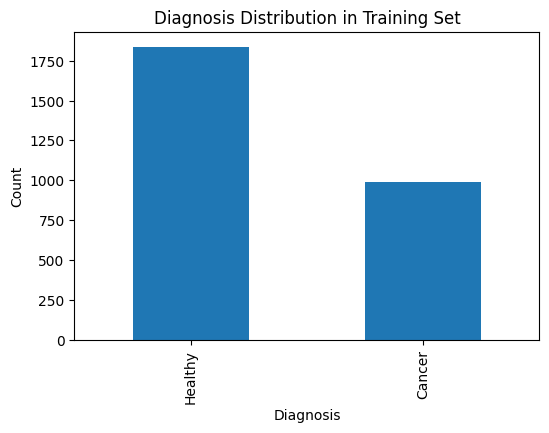

In [28]:
import matplotlib.pyplot as plt

# number of images
num_train_images = len(train_df)
num_val_images = len(val_df)
num_test_images = len(test_df)

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of test images: {num_test_images}")

# distribution of diagnoses in training set
diagnosis_counts = train_df['tumour'].replace({1:'Healthy',0:'Cancer'}).value_counts()
print("Diagnosis distribution in training set:")
print(diagnosis_counts)

# Plotting the distribution
plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar')
plt.title('Diagnosis Distribution in Training Set')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

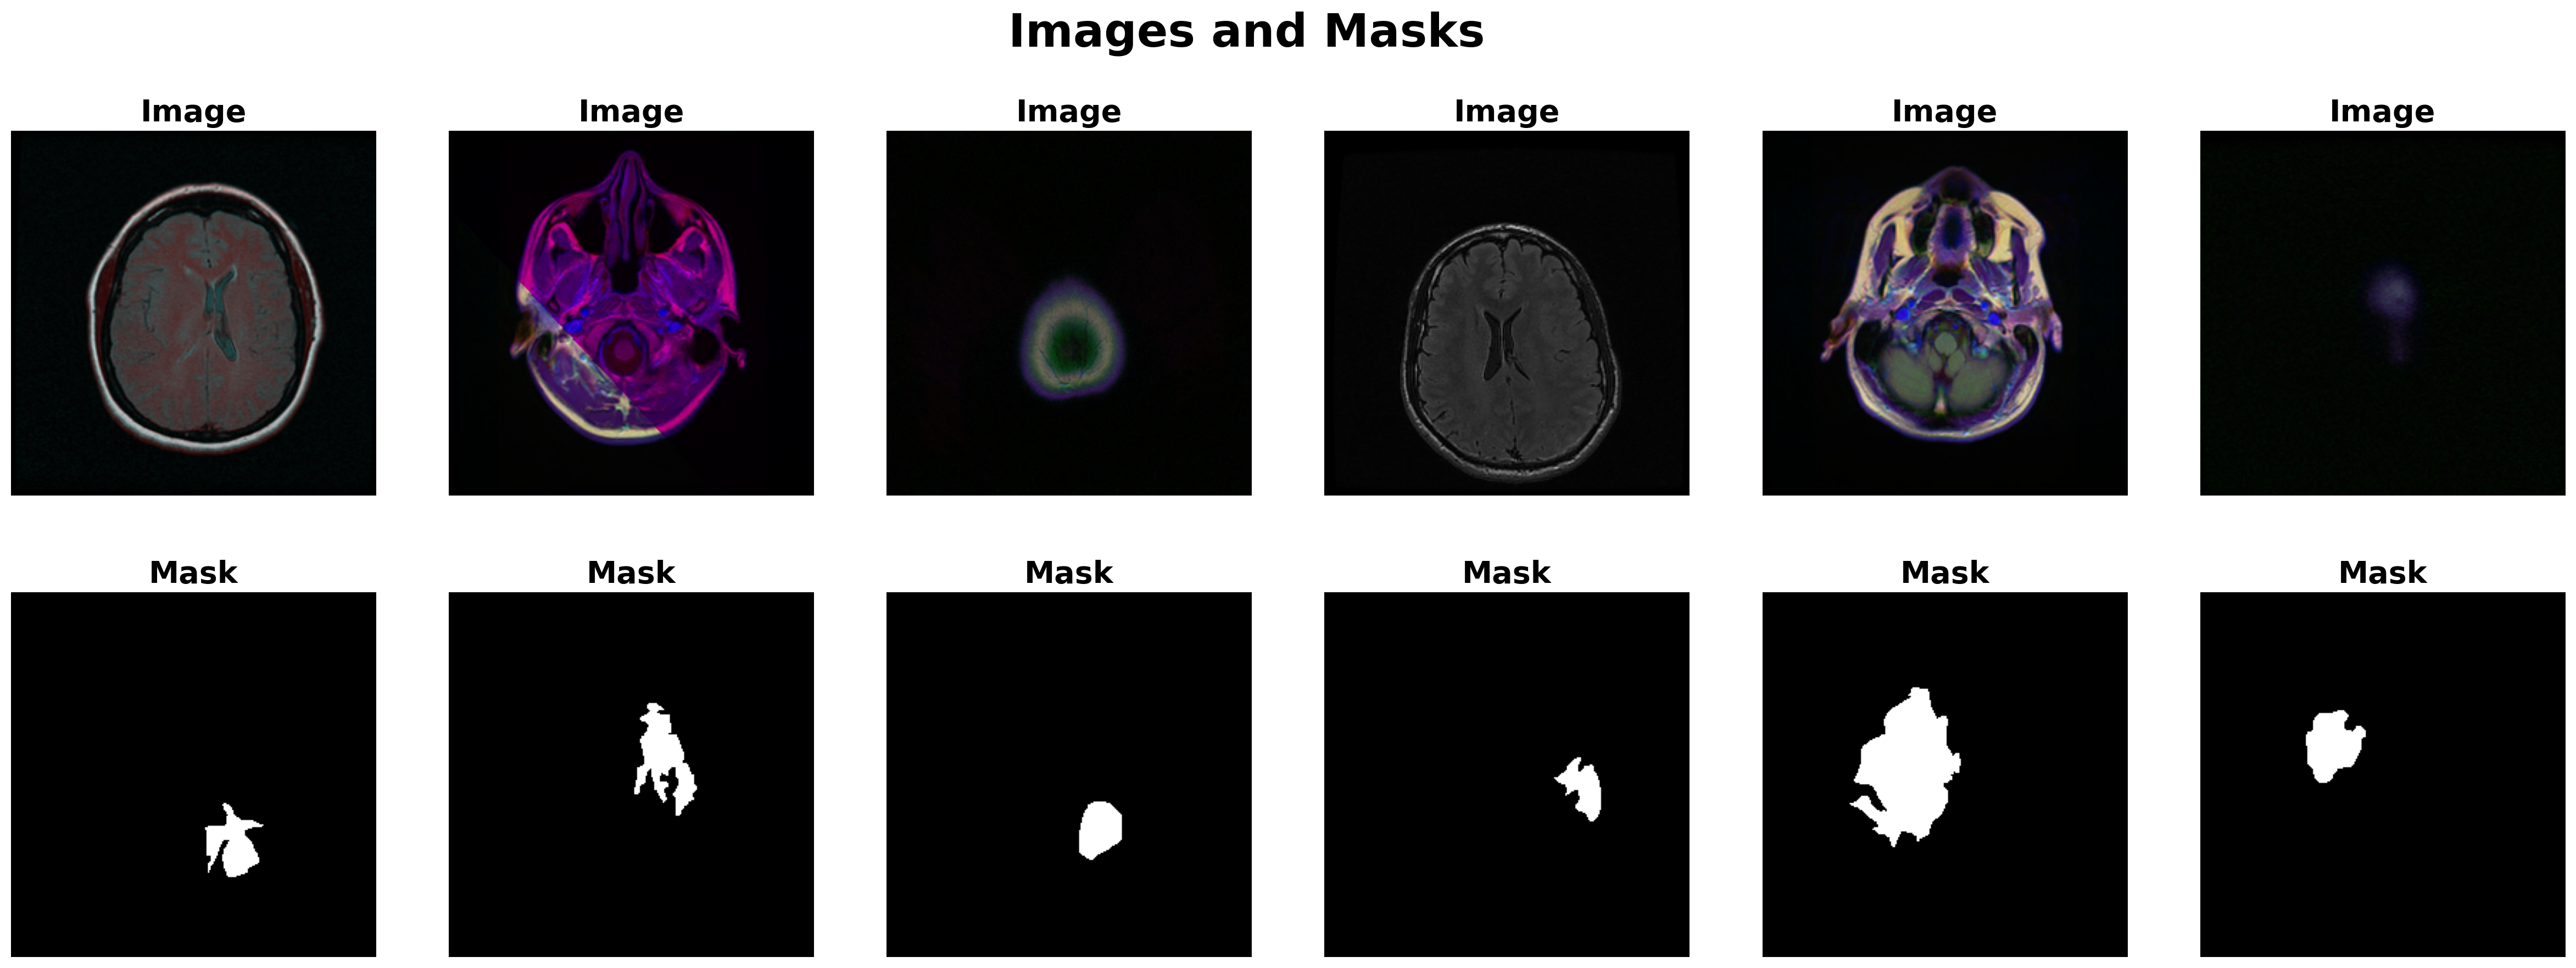

In [29]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_images_and_masks(images, masks, predictions=None, IoU_list=None):
    num_samples = len(images)

    num_rows = 2 if type(predictions) == type(None) else 3
    
    fig, axes = plt.subplots(num_rows, num_samples,
                             figsize=(num_samples*5, num_samples+(num_rows*2)), dpi=200)
    
    for i in range(num_samples):
        axes[0, i].imshow(Image.open(images[i]), cmap='gray')
        axes[0, i].set_title('Image', fontsize=20, fontweight='bold')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(Image.open(masks[i]), cmap='gray')
        axes[1, i].set_title('Mask', fontsize=20, fontweight='bold')
        axes[1, i].axis('off')
        
        if type(predictions) != type(None):
            axes[2, i].imshow(predictions[i], cmap='gray')
            axes[2, i].set_title(f'Prediction | IoU: {round(float(IoU_list[i]), 3)}',
                                 fontsize=19, fontweight='bold')
            axes[2, i].axis('off')
             
    plt.suptitle('Images and Masks', fontsize=30, fontweight='bold')
    
    plt.show()

plot_images_and_masks(train_df[train_df['tumour'] == 1]['image_path'].values[:6],
                      train_df[train_df['tumour'] == 0]['mask_path'].values[:6])

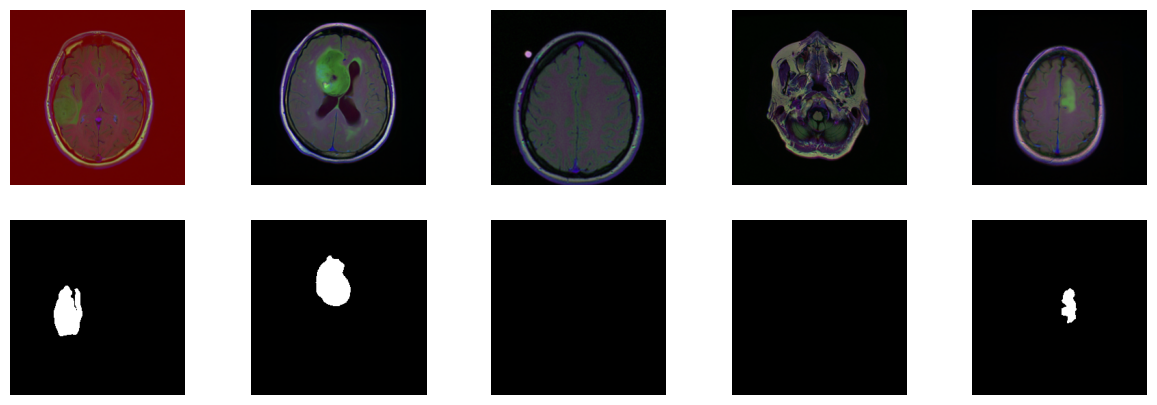

In [34]:
def show_random_images(df, num_images=5):
    plt.figure(figsize=(15, 5))
    random_images = df.sample(num_images)
    for i, row in enumerate(random_images.itertuples()):
        image = Image.open(row.image_path)
        mask = Image.open(row.mask_path)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
    plt.show()

show_random_images(train_df)

Note this is the data we crated from our given data. The given data is actully 100 patients,and we have additional infomatin about RNA and such.

        Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0  

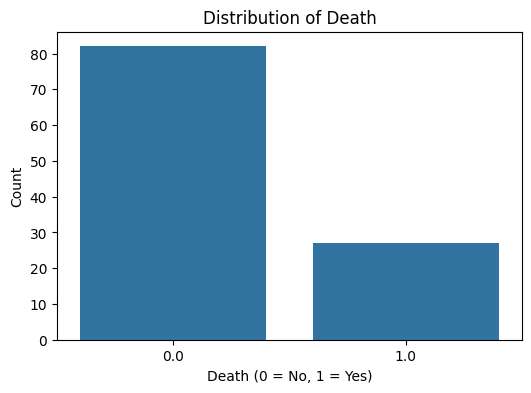

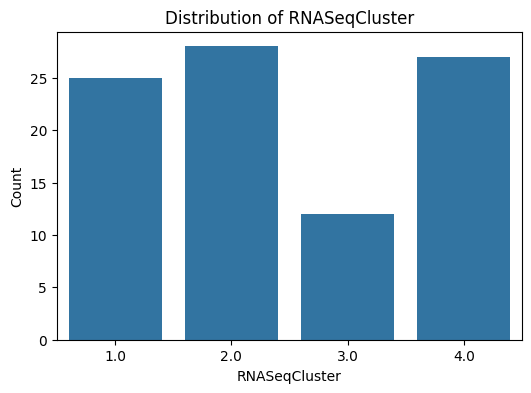

/tmp/ipykernel_4609/864180180.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_death_counts = rna_df.groupby('age_group')['death01'].sum()


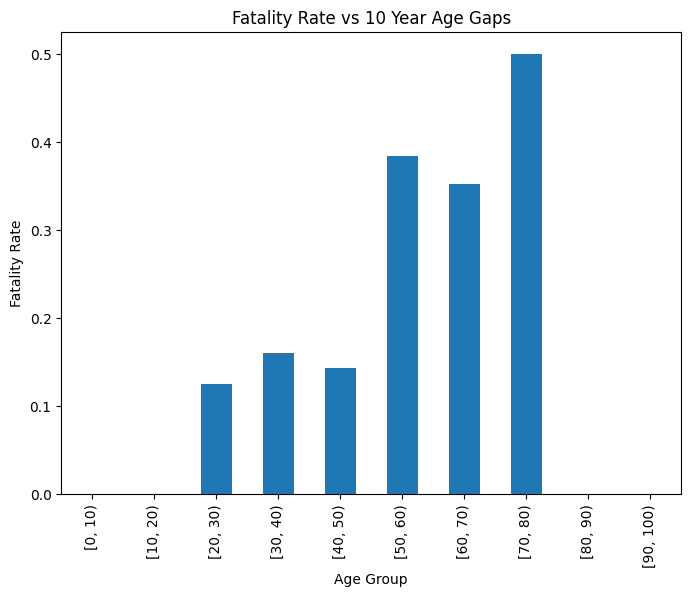

In [46]:
import pandas as pd
import seaborn as sns

rna_df = pd.read_csv('kaggle_3m/data.csv')
print(rna_df.head())
# Plotting the distribution of death01
plt.figure(figsize=(6, 4))
sns.countplot(data=rna_df, x='death01')
plt.title('Distribution of Death')
plt.xlabel('Death (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Plotting the distribution of RNASeqCluster
plt.figure(figsize=(6, 4))
sns.countplot(data=rna_df, x='RNASeqCluster')
plt.title('Distribution of RNASeqCluster')
plt.xlabel('RNASeqCluster')
plt.ylabel('Count')
plt.show()

rna_df['age_group'] = pd.cut(rna_df['age_at_initial_pathologic'], bins=range(0, 101, 10), right=False)
age_group_counts = rna_df['age_group'].value_counts().sort_index()
age_death_counts = rna_df.groupby('age_group')['death01'].sum()
fatality_rate = age_death_counts / age_group_counts

plt.figure(figsize=(8, 6))
fatality_rate.plot(kind='bar')
plt.title('Fatality Rate vs 10 Year Age Gaps')
plt.xlabel('Age Group')
plt.ylabel('Fatality Rate')
plt.show()

**CNN**

In [19]:
import torch
from torch import nn
import torch.nn.functional as F

device = res_define.device #this makes sure we have one coherent device along the notebooks

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        '''
        starts at torch.Size([4, 3, 256, 256])
        torch.Size([4, 6, 252, 252])
        torch.Size([4, 6, 126, 126])
        torch.Size([4, 16, 122, 122])
        torch.Size([4, 16, 61, 61])`
        then flattens to NN
        '''
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.reshape(-1, 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

cnn = CNN().to(device)

In [20]:
# FOR THE CASE OF SHOWING THE GRAD PLS DONT RETRAIN. THIS MIGHT CHANGE THE GRAD RESLT COMPLETLY
# res_define.train_model(cnn,train_dl,val_dl)
# torch.save(cnn.state_dict(), 'cnn.pth')

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1/8, Step 0/89, Current accuracy: 65.62%, Running loss: 0.6457
Epoch 1/8, Step 40/89, Current accuracy: 66.17%, Running loss: 0.6273
Epoch 1/8, Step 80/89, Current accuracy: 69.61%, Running loss: 0.6053
Epoch [1/8], Loss: 0.6036


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5711, Validation Accuracy: 73.73%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2/8, Step 0/89, Current accuracy: 75.00%, Running loss: 0.5538
Epoch 2/8, Step 40/89, Current accuracy: 71.48%, Running loss: 0.5725
Epoch 2/8, Step 80/89, Current accuracy: 73.44%, Running loss: 0.5664
Epoch [2/8], Loss: 0.5681


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5634, Validation Accuracy: 71.75%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3/8, Step 0/89, Current accuracy: 81.25%, Running loss: 0.5232
Epoch 3/8, Step 40/89, Current accuracy: 75.00%, Running loss: 0.5510
Epoch 3/8, Step 80/89, Current accuracy: 78.59%, Running loss: 0.5469
Epoch [3/8], Loss: 0.5501


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5559, Validation Accuracy: 74.29%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4/8, Step 0/89, Current accuracy: 81.25%, Running loss: 0.5171
Epoch 4/8, Step 40/89, Current accuracy: 75.70%, Running loss: 0.5407
Epoch 4/8, Step 80/89, Current accuracy: 80.55%, Running loss: 0.5371
Epoch [4/8], Loss: 0.5389


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5529, Validation Accuracy: 78.53%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5/8, Step 0/89, Current accuracy: 71.88%, Running loss: 0.5671
Epoch 5/8, Step 40/89, Current accuracy: 78.36%, Running loss: 0.5342
Epoch 5/8, Step 80/89, Current accuracy: 83.52%, Running loss: 0.5280
Epoch [5/8], Loss: 0.5292


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5492, Validation Accuracy: 77.26%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6/8, Step 0/89, Current accuracy: 78.12%, Running loss: 0.5409
Epoch 6/8, Step 40/89, Current accuracy: 80.62%, Running loss: 0.5253
Epoch 6/8, Step 80/89, Current accuracy: 84.06%, Running loss: 0.5228
Epoch [6/8], Loss: 0.5245


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5469, Validation Accuracy: 79.24%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7/8, Step 0/89, Current accuracy: 78.12%, Running loss: 0.5450
Epoch 7/8, Step 40/89, Current accuracy: 82.27%, Running loss: 0.5198
Epoch 7/8, Step 80/89, Current accuracy: 85.94%, Running loss: 0.5156
Epoch [7/8], Loss: 0.5175


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5378, Validation Accuracy: 80.51%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8/8, Step 0/89, Current accuracy: 81.25%, Running loss: 0.5182
Epoch 8/8, Step 40/89, Current accuracy: 84.06%, Running loss: 0.5126
Epoch 8/8, Step 80/89, Current accuracy: 83.98%, Running loss: 0.5149
Epoch [8/8], Loss: 0.5176


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5485, Validation Accuracy: 77.40%
Training completed!


although this is not an impressive result, we use the cnn example to showcase the grad-cam. as we will see later, because cnn has more FC-layers it results in a nicer heatmap, unlike the even more convolution based models that result in only a circular bump.

In [5]:
cnn.load_state_dict(torch.load('cnn.pth'))
cnn.eval()

/tmp/ipykernel_3932/2790479405.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load('cnn.pth'))


CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

**CNN GRAD**

We visualize what are the activations on the last layer of the model,taking the derivitive in respect to the classification. This is the main idea of GRAD-CAM.

In practice we use more advanced methods, such as Eigen (simillar but uses eigen values to determine the importance) and XGrad.

In [21]:
from pytorch_grad_cam import EigenCAM,AblationCAM,XGradCAM

cnn_visualize_prediction = lambda x : res_define.visualize_prediction(cnn,[cnn.conv2],x,[EigenCAM,AblationCAM])
cnn_visualize_cheap = lambda x : res_define.visualize_prediction(cnn,[cnn.conv2],x,[XGradCAM,AblationCAM])

100%|██████████| 1/1 [00:00<00:00, 42.89it/s]


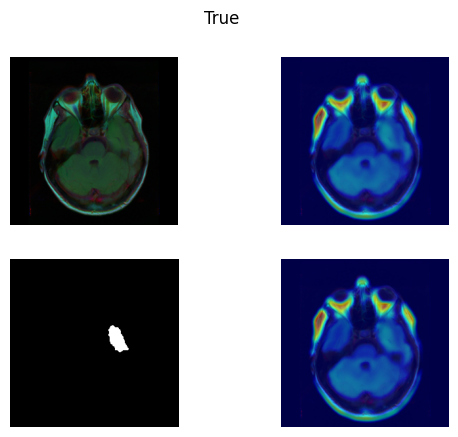

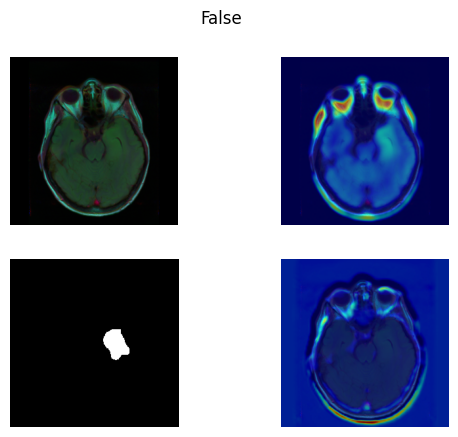

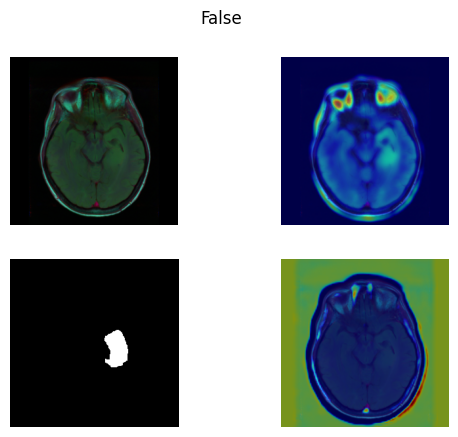

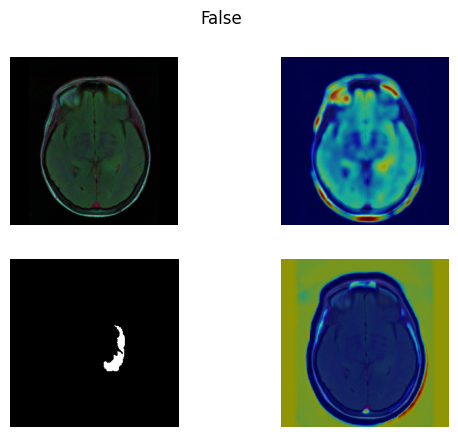

In [22]:
# We advice to skip calling all 4 if you dont want to wait, this is very memory and cpu heavy
# You can also try and compare it with the cheap visualization
cnn_visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8.tif')
cnn_visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_9.tif')
cnn_visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10.tif')
cnn_visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_11.tif')

100%|██████████| 1/1 [00:00<00:00, 42.27it/s]


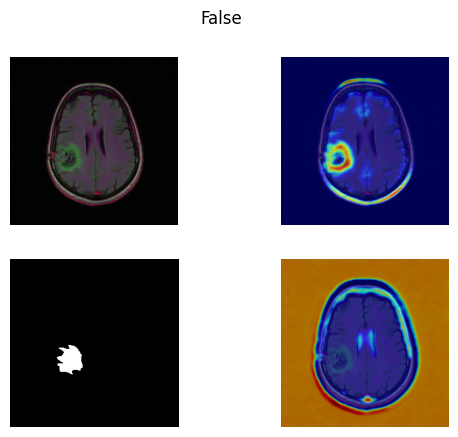

In [23]:
cnn_visualize_cheap('kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_27.tif')

You can see some intresting things
- It looks like the cnn learns the edge of the brain too. We can see the activation on the edge between the brain and the background
- Even when the classification is wrong, we can see the cancer in the heatmap. this means even if the network was wrong, it did determine correctly it is an anomaly

Note that we used EigenCam which is very cosly, this was the only method to give good results (prob because the complex FC layers needed more complex model to explain). this is why we move to even more conv baed models in the next section

**RES + ENSAMBLE GRAD**

The CNN architecture came at 1990, since then we had Windows 2.2, SMS, and Google

We use resnet, efficientnet and ensamble of both for prediction, using pretrained model on general images.
To summerize, this models are conv based models, that use bottolenecks and inflation of channels (extending the image even more in the third dimension) to learn.

In [5]:
import torchvision.models as models

device = res_define.device
resnet = models.resnet18(pretrained=True)

# Modify the last layer for binary classification
num_classes = 1  
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, num_classes),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

resnet = resnet.to(device)

/home/sagie/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagie/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
#if you want to try and train yourself on you computer
# res_define.train_model(resnet,train_dl,val_dl)
# torch.save(resnet.state_dict(), 'resnet.pth')

In [9]:
#if you want to load from our save
resnet.load_state_dict(torch.load('resnet.pth'))

/tmp/ipykernel_4609/581440355.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load('resnet.pth'))


<All keys matched successfully>

In [10]:
resnet.eval()
res_define.test_model(resnet,test_dl)

Accuracy of the network on the test images: 82 %
Precision of the network on the test images: 0.841584
Recall of the network on the test images: 0.620438


100%|██████████| 16/16 [00:01<00:00,  8.46it/s]


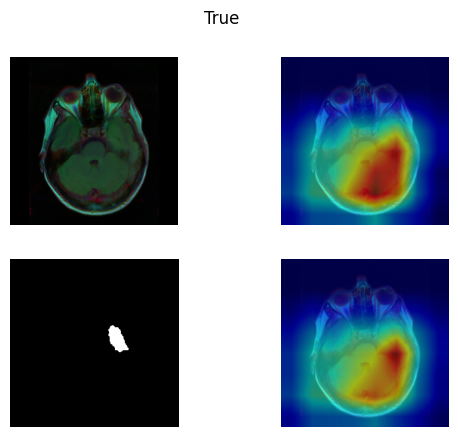

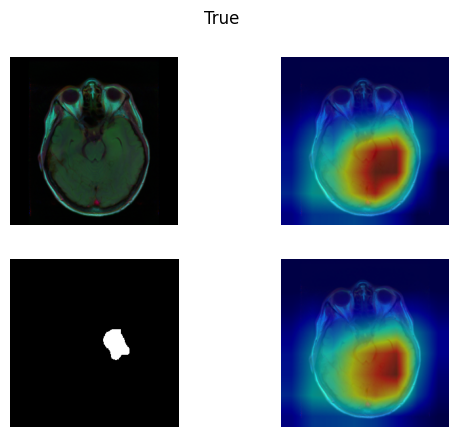

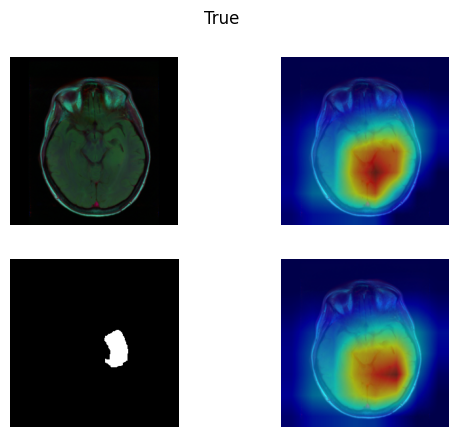

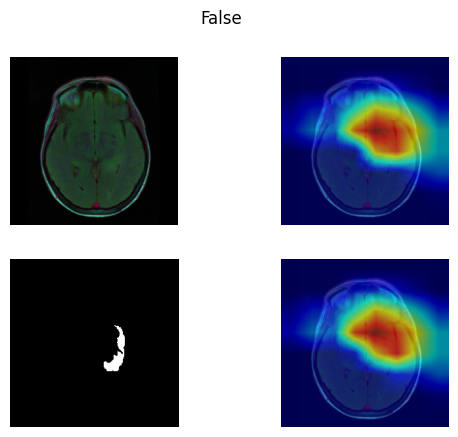

In [11]:
res_define.visualize_prediction(resnet,resnet.layer4,'kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8.tif')
res_define.visualize_prediction(resnet,resnet.layer4,'kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_9.tif')
res_define.visualize_prediction(resnet,resnet.layer4,'kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10.tif')
res_define.visualize_prediction(resnet,resnet.layer4,'kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_11.tif')

This is not that good, we can do better!

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models

# device = res_define.device
device = 'cpu'

# Load pre-trained EfficientNet model
efficientnet = models.efficientnet_b0(pretrained=True)

# Modify the last layer for binary classification
num_classes = 1  
efficientnet.classifier[1] = nn.Sequential(
    nn.Linear(efficientnet.classifier[1].in_features, num_classes),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

# Move the model to the appropriate device
efficientnet = efficientnet.to(device)

# pre-trained ResNet model
resnet2 = models.resnet18(pretrained=True)

# Modify the last layer for binary classification
num_classes = 1  
resnet2.fc = nn.Sequential(
    nn.Linear(resnet2.fc.in_features, num_classes),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

resnet2 = resnet2.to(device) # here you accedently put resnet2 = resnet.to with the old model

In [16]:
# Instantiate the ensemble model
ensemble_model = res_define.EnsembleModel(resnet2, efficientnet)
ensemble_model = ensemble_model.to(device)

In [14]:
#if you want to train it yourself
# res_define.train_ensamble(ensemble_model,train_dl,val_dl)

In [17]:
#if you want to load our trained
# Saving the model
# torch.save(ensemble_model.state_dict(), 'ensemble_model.pth')

# Loading the model
ensemble_model.load_state_dict(torch.load('ensemble_model.pth'))

/tmp/ipykernel_4609/127292697.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ensemble_model.load_state_dict(torch.load('ensemble_model.pth'))


<All keys matched successfully>

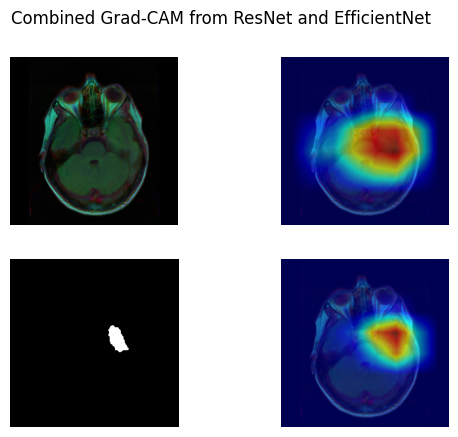

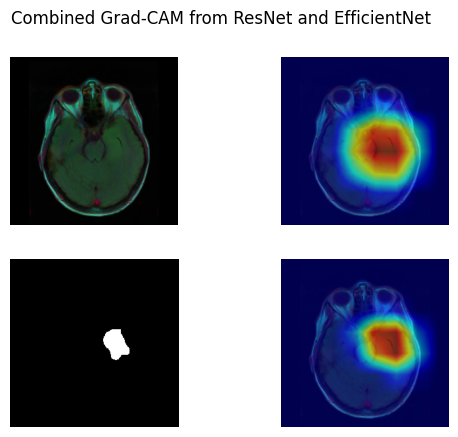

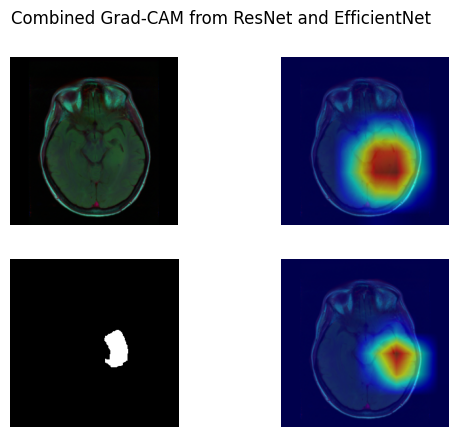

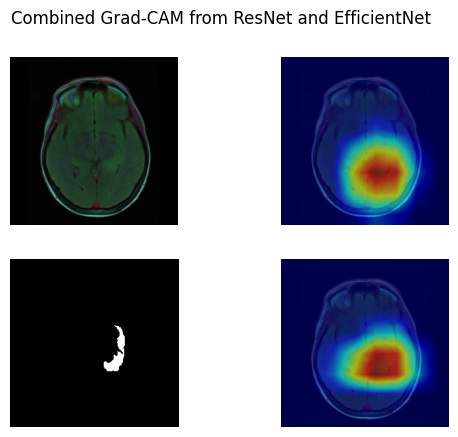

In [18]:

# Define the target layers for Grad-CAM
target_layers_resnet = [ensemble_model.modelA.layer4[-1]]  # Last convolutional layer in ResNet
target_layers_efficientnet = [ensemble_model.modelB.features[8][0]]  # Last convolutional layer in EfficientNet

visualize_ensemble_gradcam = lambda x : res_define.visualize_ensemble_gradcam(x,ensemble_model,target_layers_resnet,target_layers_efficientnet)

# Example usage
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8.tif')
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_9.tif')
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10.tif')
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_11.tif')

Works quick and gives an indecation to which area, the grad is so rectangular because this model is just made with norm and conv layers. thus everything will be made of chunks and not a smooth map like the FC layers of the CNN

In [ ]:
res_define.test_model(ensemble_model,test_dl)

Accuracy of the network on the test images: 98 %
Precision of the network on the test images: 0.978102
Recall of the network on the test images: 0.978102


This is so beutiful, brings a tear into our eyes

**DEATH PREDICTION**

Now we will try to combine our death01 data, and altough we arent GOD, we will try to predict fatality of each patiant.
This task is important to allow quality rest of life to paitents, and predict if treatment will help, or to let them enjoy the time they have.

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch
# device = res_define.device
device = 'cpu'

class CombinedModel(nn.Module):
    def __init__(self,img_model,img_size,fc1_size,fc2_size):
        super(CombinedModel, self).__init__()
        self.img_model = img_model
        self.fc1 = nn.Linear(36 + img_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, 1)

    def forward(self, x,rna):
        batch_size, timesteps, C, H, W = x.size()
        x = x.view(timesteps, C, H, W)
        x = self.img_model(x)
        x = x.view(batch_size, timesteps, -1)
        x = torch.mean(x,1)
        x = torch.cat((x,rna),1)
        x = F.sigmoid(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
resnet3 = models.resnet18(pretrained=True)

embedding_size = 5

resnet3.fc = nn.Sequential(
    nn.Linear(resnet3.fc.in_features, embedding_size),
)

resnet3 = resnet3.to(device)
deathnet = CombinedModel(resnet3,embedding_size,50,30).to(device)

/home/sagie/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagie/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


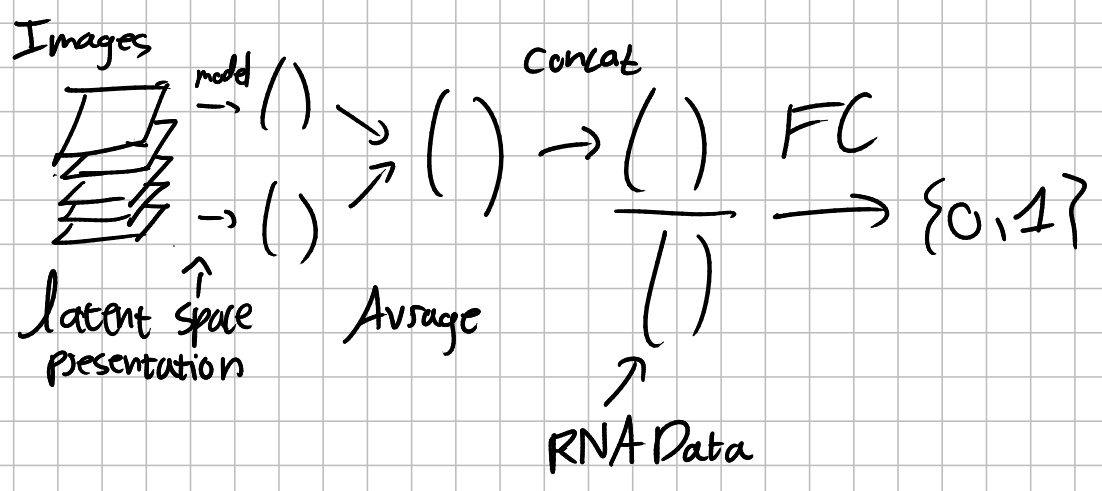

In [ ]:
death_train,death_test = res_define.death_data('cpu')

In [ ]:
# res_define.death_train(deathnet,death_train)
# WE TRAINED IT OUTSIDE THE NOTEBOOK BECAUSE IPYNB KERNAL IS SLOWER. THE FILE IS death.py

In [ ]:
deathnet.load_state_dict(torch.load('deathnet.pth'))

/tmp/ipykernel_43899/2995938982.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deathnet.load_state_dict(torch.load('deathnet.pth'))


<All keys matched successfully>

In [ ]:
res_define.death_test(deathnet,death_test)
# Note here that the positive case is the patiant lives.
# Thus if we think that the patiant will live, he will, but 78% of predicted deaths could live :(
# We think this is better as treatment is very hard. but we can change the threshould if we want

Accuracy of the network on the test images: 81 %
Precision of the network on the test images: 1.000000
Recall of the network on the test images: 0.777778


This was a very fun project. We learned Alot and enjoyed the course although it was very demnading. Thanks A LOT.